In [1]:
!pip install pybullet imageio-ffmpeg

import os
import time
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data as pd
import cv2
import imageio_ffmpeg
from base64 import b64encode
from IPython.display import HTML


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 4.6 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/Gaianeve/Real_Mega_Fufi.git
%cd Real_Mega_Fufi/Robot/Single_joint_trial

Cloning into 'Real_Mega_Fufi'...
remote: Enumerating objects: 1233, done.
remote: Counting objects: 100% (676/676), done.
remote: Compressing objects: 100% (332/332), done.
remote: Total 1233 (delta 515), reused 476 (delta 343), pack-reused 557 (from 1)
Receiving objects: 100% (1233/1233), 12.37 MiB | 15.99 MiB/s, done.
Resolving deltas: 100% (828/828), done.
/content/Real_Mega_Fufi/Robot/Single_joint_trial


In [12]:
#connecting
p.connect(p.DIRECT)

# using FEM
p.resetSimulation(p.RESET_USE_DEFORMABLE_WORLD)
#set sampling time
p.setGravity(0, 0, -9.81)
# set sampling time: if too high it becomes instable
#p.setTimeStep(0.0001)
#p.setPhysicsEngineParameter(numSolverIterations=2000)
# Aggiungi il percorso dei dati PyBullet for the plane
p.setAdditionalSearchPath(pd.getDataPath())


In [13]:
useFixedBase_flag = True
plane_pos = [0,0,-0.04]
plane = p.loadURDF("plane.urdf", plane_pos, useFixedBase=useFixedBase_flag)

elastic_joint_id = p.loadSoftBody("elastic_joint_center.obj",
                                  mass=0.0569,  # Calcolare in base al volume del modello
                                  useNeoHookean=1,
                                  NeoHookeanMu=76.92e9,  # Shear modulus (calculated)
                                  NeoHookeanLambda=115.38e9,  # First Lamé parameter (calculated)
                                  #NeoHookeanDamping=0.07,  # Moderate damping
                                  #collisionMargin=0.03,
                                  #useSelfCollision=0,
                                  #frictionCoeff=0.8,
                                  springElasticStiffness=300e9,  # Increased stiffness
                                  springDampingStiffness=30e9,  # Added damping (proportional to stiffness)
                                  springBendingStiffness=300e9,  # Increased bending stiffness
                                  #useFaceContact=1
                                )
#arancione
p.changeVisualShape(elastic_joint_id, -1, rgbaColor=[1, 0.65, 0, 1])


In [14]:

# Parametri della fotocamera
cam_target_pos = [0, 0, 0]
cam_distance = 0.5
cam_yaw, cam_pitch, cam_roll = 0, 0, 0
cam_width, cam_height = 480, 360
cam_up_axis_idx = 2
cam_fov = 60
cam_near_plane, cam_far_plane = 0.01, 100

# Imposta la registrazione del video
vid = imageio_ffmpeg.write_frames('simulation_output.mp4', (cam_width, cam_height), fps=30)
vid.send(None)  # Inizializza con un fotogramma vuoto



In [15]:
joint_positions_x, joint_positions_y, joint_position_z = [], [], []
joint_positions_down_z, joint_positions_up_z = [], []

In [16]:
# Ciclo principale della simulazione
for step in range(30):
    #get joint position
    joint_position, joint_orientation = p.getBasePositionAndOrientation(elastic_joint_id)
    joint_positions_x.append(joint_position[0])
    joint_positions_y.append(joint_position[1])
    joint_position_z.append(joint_position[2])

    #get joint vertex positions
    mesh_data = p.getMeshData(elastic_joint_id, flags=p.MESH_DATA_SIMULATION_MESH)
    node_positions = mesh_data[1]  # Posizioni dei nodi
    joint_positions_down_z.append(node_positions[0][2])
    joint_positions_up_z.append(node_positions[1][2])

    # Aggiorna il video
    # Calcola la vista e la proiezione della fotocamera
    cam_view_matrix = p.computeViewMatrixFromYawPitchRoll(
        cam_target_pos, cam_distance, cam_yaw, cam_pitch, cam_roll, cam_up_axis_idx
    )
    cam_projection_matrix = p.computeProjectionMatrixFOV(
        cam_fov, cam_width / cam_height, cam_near_plane, cam_far_plane
    )

    # Cattura l'immagine
    image = p.getCameraImage(cam_width, cam_height, cam_view_matrix, cam_projection_matrix)[2][:, :, :3]

    # Scrivi il fotogramma nel video
    vid.send(np.ascontiguousarray(image))

    p.stepSimulation()  # Avanza di un passo nella simulazione

# Rilascia le risorse video
vid.close()


In [17]:
# Disconnessione dalla simulazione
p.disconnect()
# Leggi il file video
mp4 = open('simulation_output.mp4', 'rb').read()

# Convertilo in Base64
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# Visualizza il video nel notebook Jupyter
HTML(f'<video width="600" controls><source src="{data_url}" type="video/mp4"></video>')

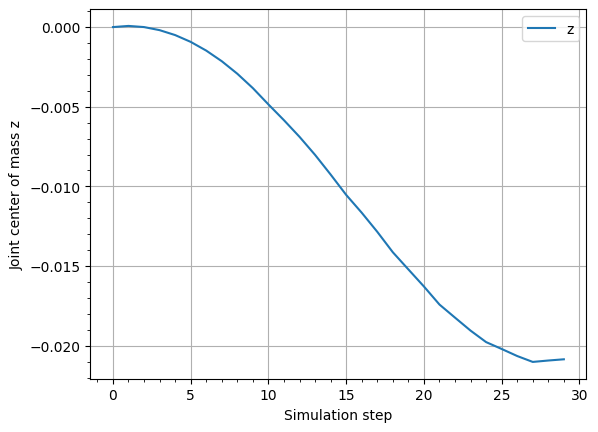

In [18]:
plt.figure()
plt.plot(joint_position_z, label = 'z')
plt.xlabel('Simulation step')
plt.ylabel('Joint center of mass z')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

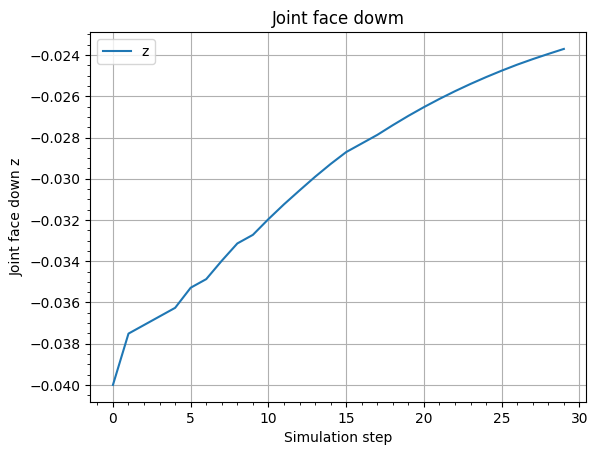

In [19]:
plt.figure()
plt.title("Joint face dowm")
plt.plot(joint_positions_down_z, label = 'z')
plt.xlabel('Simulation step')
plt.ylabel('Joint face down z')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

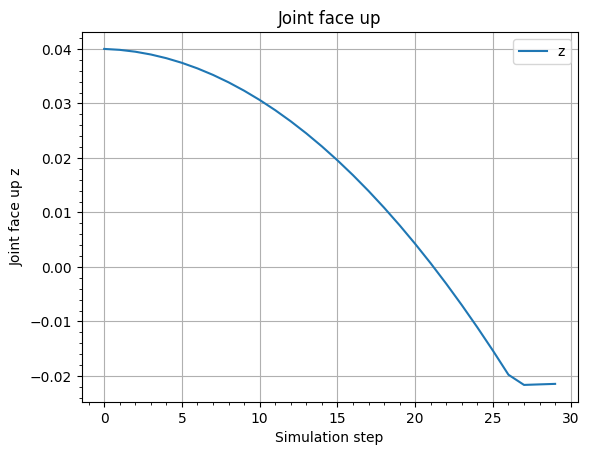

In [20]:
plt.figure()
plt.title("Joint face up")
plt.plot(joint_positions_up_z, label = 'z')
plt.xlabel('Simulation step')
plt.ylabel('Joint face up z')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()